In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from collections import defaultdict

In [2]:
#import wget
#wget.download("https://archive.ics.uci.edu/static/public/222/bank+marketing.zip")

In [3]:
df = pd.read_csv("../data/bank-full.csv", delimiter=";")

# select columns to work with
columns_to_select = ['age', 'job', 'marital',
                     'education', 'balance', 'housing',
                     'contact', 'day', 'month', 'duration',
                     'campaign', 'pdays', 'previous',
                     'poutcome', 'y']

df = df[columns_to_select]

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# encode y-target

df["y"] = df["y"].map({"no":0, "yes":1}) 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1



In [5]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

print(f'Len train: {df_train.shape[0]}\nLen test: {df_test.shape[0]}\nLen val: {df_val.shape[0]}')

Len train: 27126
Len test: 9043
Len val: 9042


In [6]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. 

You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [7]:
numeric_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

for feature in numeric_features:
    score = roc_auc_score(df_train.y, df_train[feature], multi_class='ovr')
    print(f"{feature}: {score:.3f}")

age: 0.488
balance: 0.589
day: 0.474
duration: 0.815
campaign: 0.429
pdays: 0.590
previous: 0.599


### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)


In [8]:
y_train = df_train["y"].values
y_test = df_test["y"].values
y_val = df_val["y"].values

df_train.drop(columns=["y"], inplace=True)
df_test.drop(columns=["y"], inplace=True)
df_val.drop(columns=["y"], inplace=True)   

In [9]:
vectorizer = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
X_train = vectorizer.fit_transform(train_dict)

test_dict = df_test.to_dict(orient="records")
X_test = vectorizer.fit_transform(test_dict)

val_dict = df_val.to_dict(orient="records")
X_val = vectorizer.fit_transform(val_dict)

In [10]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train, y_train)

y_logits = lr.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_logits)

print(f'Auc: {auc_score:.3f}')

Auc: 0.900


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?


In [11]:
thresholds = np.linspace(0, 1, 100)   

precision_scores = {}
recall_scores = {}

for t in thresholds: 

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_logits >= t)
    predict_negative = (y_logits < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    precision_scores[t] = precision
    recall_scores[t] = recall

    # we need to check at what threshold precision and recall are the same
    epsilon = 0.01
    
    if abs(precision - recall) < epsilon: 
        print(f'We have intersection around {t:.3f} threshold value')
        

We have intersection around 0.263 threshold value


/var/folders/ct/6y14r9zn1kj3j9kqvchn0lsm0000gn/T/ipykernel_54300/3165380672.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


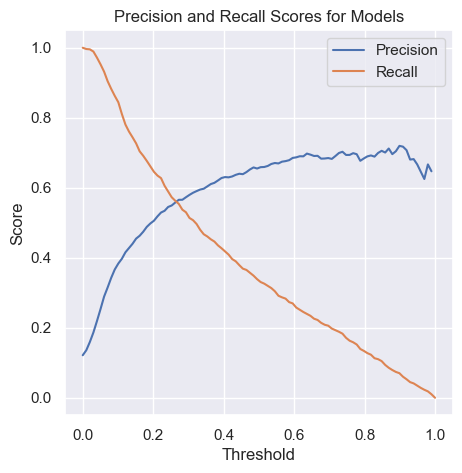

In [12]:
sns.set_theme()

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(thresholds, list(precision_scores.values()), label='Precision')
plt.plot(thresholds, list(recall_scores.values()), label='Recall')

plt.title('Precision and Recall Scores for Models')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

plt.show()

### Question 4: F1 score


Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [13]:
thresholds = np.linspace(0, 1, 100)   

best_t, max_f1 = 0, float("-inf")

for t in thresholds: 

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_logits >= t)
    predict_negative = (y_logits < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    f1 = 2 * (precision * recall) / (precision + recall)

    if f1 > max_f1: 
        best_t = t
        max_f1 = f1

/var/folders/ct/6y14r9zn1kj3j9kqvchn0lsm0000gn/T/ipykernel_54300/3004040440.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [14]:
print(f'Max f1 score {max_f1:.3f} on threshold {best_t:.3f}')

Max f1 score 0.574 on threshold 0.222


### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_full_train = df_train_val # in my definition it is df_train_val

print(f"shape: {df_full_train.shape[0]}")

shape: 36168


In [16]:
auc_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(df_full_train)):
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = df_train["y"].values
    y_val = df_val["y"].values

    df_train.drop(columns=["y"], inplace=True)
    df_val.drop(columns=["y"], inplace=True)   

    train_dict = df_train.to_dict(orient="records")
    X_train = vectorizer.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient="records")
    X_val = vectorizer.fit_transform(val_dict)

    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    lr.fit(X_train, y_train)

    y_logits = lr.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_logits)

    auc_scores += [auc_score]

In [17]:
print(f'Std of auc scores is: {np.std(auc_scores):.3f}')

Std of auc scores is: 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]

Initialize KFold with the same parameters as previously

Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [18]:
c_values = [0.000001, 0.001, 1]

auc_scores = defaultdict(list)

for fold, (train_index, val_index) in enumerate(kf.split(df_full_train)):
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = df_train["y"].values
    y_val = df_val["y"].values

    df_train.drop(columns=["y"], inplace=True)
    df_val.drop(columns=["y"], inplace=True)   

    train_dict = df_train.to_dict(orient="records")
    X_train = vectorizer.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient="records")
    X_val = vectorizer.fit_transform(val_dict)

    for C in c_values:
        lr = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        lr.fit(X_train, y_train)

        y_logits = lr.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_logits)

        auc_scores[C] += [auc_score]

In [19]:
for C in auc_scores.keys(): 
    print(f"C value: {C} with mean roc auc: {np.mean(auc_scores[C]):.3f}")

C value: 1e-06 with mean roc auc: 0.701
C value: 0.001 with mean roc auc: 0.861
C value: 1 with mean roc auc: 0.906
